# K-Fold CV for Boosting Methods Using SKLearn 

In [1]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd

In [2]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

C:\Users\Luke\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [4]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


In [5]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)

In [6]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))

22


In [7]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn', 'Rhythm', 'Subject'],
      dtype='object')


# Extreme Gradient Boosting

1.5.1


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


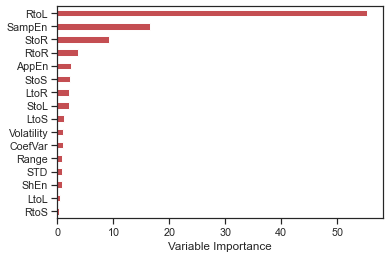

roc_auc_score 0.9764999543392895


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


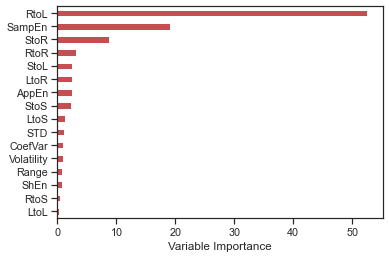

roc_auc_score 0.9857078444904531


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


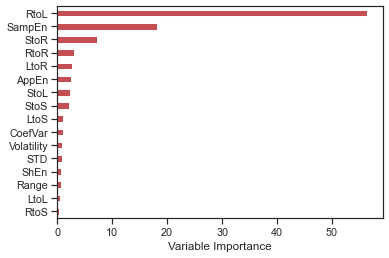

roc_auc_score 0.9992859253422633


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


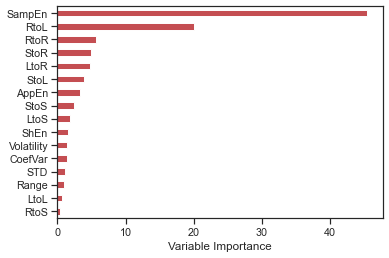

roc_auc_score 0.987531744833877


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


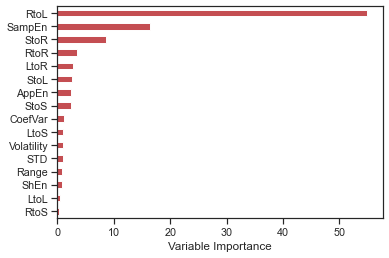

roc_auc_score 0.9999988074865991


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


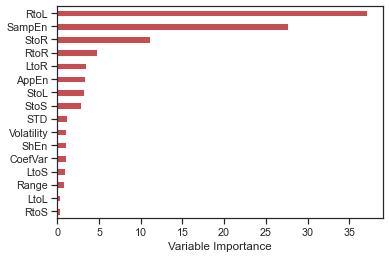

roc_auc_score 0.9924046641130955


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


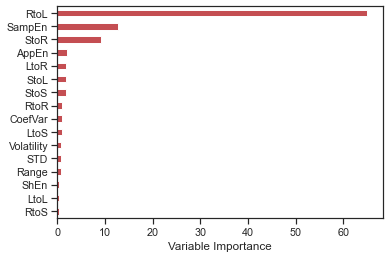

roc_auc_score 0.8915286165061749


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


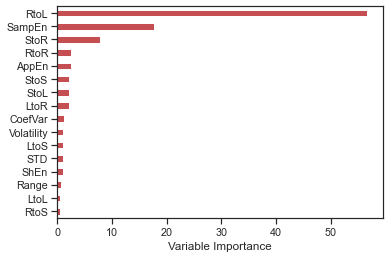

roc_auc_score 0.9990437158469946


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


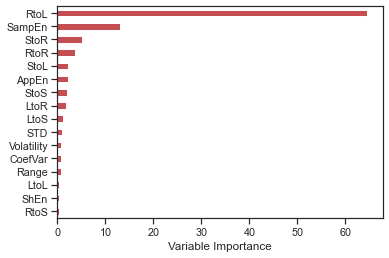

roc_auc_score 0.973566122511666


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


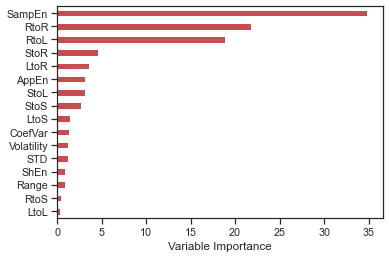

roc_auc_score 0.9952546806795541


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


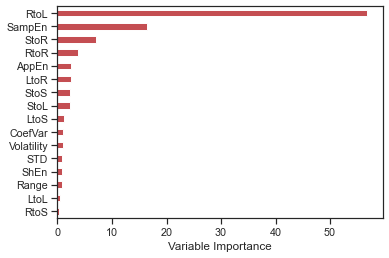

roc_auc_score 0.9363290499068987


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


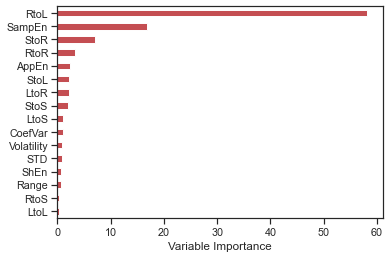

roc_auc_score 0.9649880300957592


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


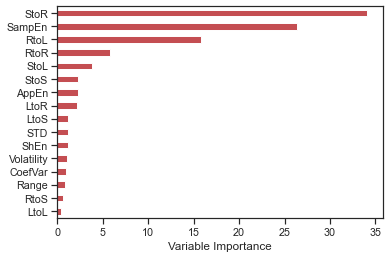

roc_auc_score 0.9629530903687908


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


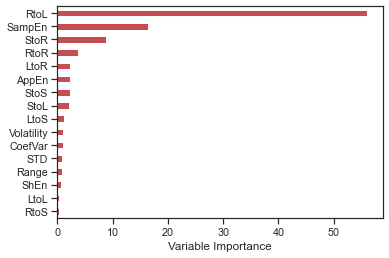

ROC_AUC not able to be calculated for subject 07162


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


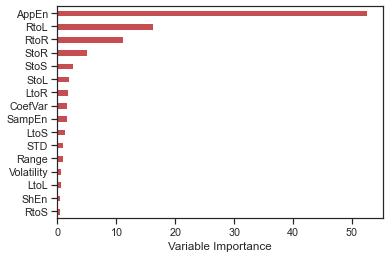

ROC_AUC not able to be calculated for subject 07859


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


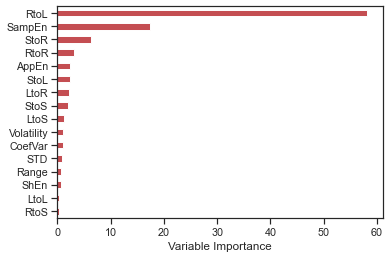

roc_auc_score 0.9984787509424717


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


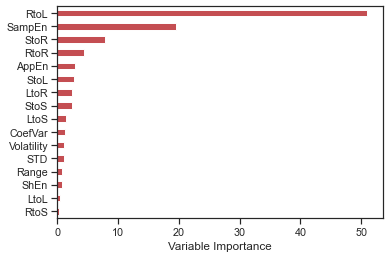

roc_auc_score 0.9988412297916083


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


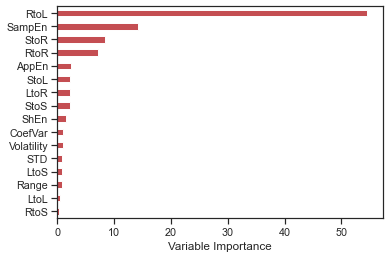

roc_auc_score 0.9993739797162042


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


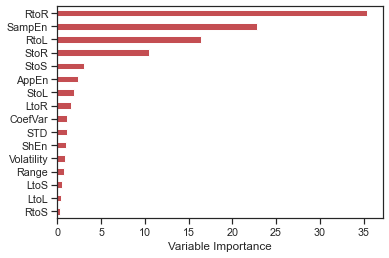

roc_auc_score 0.9585936584222248


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


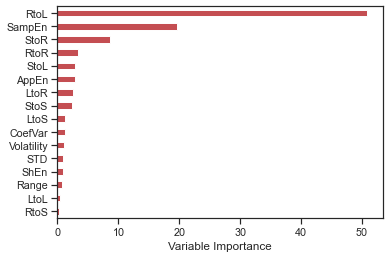

roc_auc_score 0.9939800846354794


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


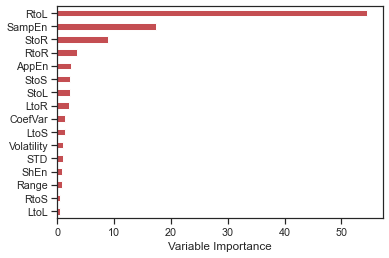

roc_auc_score 0.9992007321537523


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


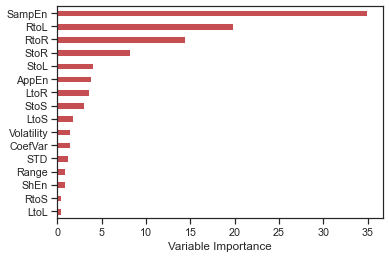

roc_auc_score 0.9999283154121863


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


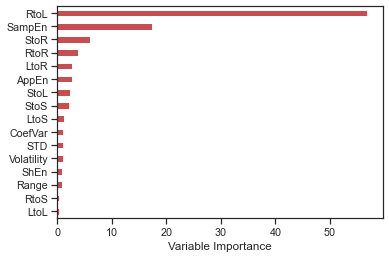

roc_auc_score 0.9999020242718537
---Run time is 90.93166749999999 seconds ---

Accuracy of each fold: 
 [0.914187643020595, 0.954158215010142, 0.9962216624685138, 0.935251798561151, 0.9968652037617555, 0.9525354969574037, 0.7888836992059786, 0.998638529611981, 0.9392570281124498, 0.9685777287761852, 0.9823049001814882, 0.990667623833453, 0.8249433106575964, 0.9535031847133758, 0.5961698584512906, 0.9906956136464333, 0.9910897875257025, 0.9878822850548182, 0.742603550295858, 0.9692138537658054, 0.9961505560307955, 0.9968612680477087, 0.9987315010570824]

Avg accuracy : 
0.9332780129890246

Std of accuracy : 
0.09926188579723327


In [8]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# check xgboost version
import xgboost
import xgboost as xgb
from xgboost import XGBClassifier
print(xgboost.__version__)
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)#, random_state=1)
# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')
    
from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]

    
    model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    plt.show()
    #plt.savefig('plot1.png')
    
    ##################################################
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    try:
        print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    except:
        print(f'ROC_AUC not able to be calculated for subject {subject}')
    # calculate the fpr and tpr for all thresholds of the classification
    #fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
    #roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    #import matplotlib.pyplot as plt
    #plt.title('Receiver Operating Characteristic')
    #plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([-0.05, 1])
    #plt.ylim([0, 1.05])
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.show()
    ##################################################
    
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

# Reference: 

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

max_depth (int, optional (default=-1)) – Maximum tree depth for base learners, <=0 means no limit.

learning_rate (float, optional (default=0.1)) – Boosting learning rate. You can use callbacks parameter of fit method to shrink/adapt learning rate in training using reset_parameter callback. Note, that this will ignore the learning_rate argument in training.

n_estimators (int, optional (default=100)) – Number of boosted trees to fit.

eval_metric (str, callable, list or None, optional (default=None)) – If str, it should be a built-in evaluation metric to use. If callable, it should be a custom evaluation metric, see note below for more details. If list, it can be a list of built-in metrics, a list of custom evaluation metrics, or a mix of both. In either case, the metric from the model parameters will be evaluated and used as well. 
Default: ‘l2’ for LGBMRegressor, **‘logloss’ for LGBMClassifier**, ‘ndcg’ for LGBMRanker.


C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618356	valid_0's binary_logloss: 0.571408
[2]	training's binary_logloss: 0.55755	valid_0's binary_logloss: 0.521635
[3]	training's binary_logloss: 0.505937	valid_0's binary_logloss: 0.479841
[4]	training's binary_logloss: 0.461077	valid_0's binary_logloss: 0.444658
[5]	training's binary_logloss: 0.422435	valid_0's binary_logloss: 0.413974
[6]	training's binary_logloss: 0.38893	valid_0's binary_logloss: 0.388499
[7]	training's binary_logloss: 0.359628	valid_0's binary_logloss: 0.365992
[8]	training's binary_logloss: 0.333592	valid_0's binary_logloss: 0.347248
[9]	training's binary_logloss: 0.310354	valid_0's binary_logloss: 0.331608
[10]	training's binary_logloss: 0.289934	valid_0's binary_logloss: 0.3166
[11]	training's binary_logloss: 0.271768	valid_0's binary_logloss: 0.30428
[12]	training's binary_logloss: 0.255338	valid_0's binary_logloss: 0.293393
[13]	training's binary_logloss: 0.240926	valid_0's binary_logloss: 0.283978
[14]	training's binary_log

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618031	valid_0's binary_logloss: 0.587241
[2]	training's binary_logloss: 0.557826	valid_0's binary_logloss: 0.529984
[3]	training's binary_logloss: 0.506602	valid_0's binary_logloss: 0.481112
[4]	training's binary_logloss: 0.462222	valid_0's binary_logloss: 0.439001
[5]	training's binary_logloss: 0.423927	valid_0's binary_logloss: 0.403011
[6]	training's binary_logloss: 0.390805	valid_0's binary_logloss: 0.372501
[7]	training's binary_logloss: 0.361395	valid_0's binary_logloss: 0.345071
[8]	training's binary_logloss: 0.3355	valid_0's binary_logloss: 0.321059
[9]	training's binary_logloss: 0.31264	valid_0's binary_logloss: 0.299863
[10]	training's binary_logloss: 0.292282	valid_0's binary_logloss: 0.281108
[11]	training's binary_logloss: 0.27437	valid_0's binary_logloss: 0.264228
[12]	training's binary_logloss: 0.258109	valid_0's binary_logloss: 0.249421
[13]	training's binary_logloss: 0.243597	valid_0's binary_logloss: 0.23621
[14]	training's binary_log

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618971	valid_0's binary_logloss: 0.555954
[2]	training's binary_logloss: 0.558959	valid_0's binary_logloss: 0.494263
[3]	training's binary_logloss: 0.507991	valid_0's binary_logloss: 0.440917
[4]	training's binary_logloss: 0.464155	valid_0's binary_logloss: 0.395268
[5]	training's binary_logloss: 0.425893	valid_0's binary_logloss: 0.355017
[6]	training's binary_logloss: 0.392805	valid_0's binary_logloss: 0.319867
[7]	training's binary_logloss: 0.36368	valid_0's binary_logloss: 0.28888
[8]	training's binary_logloss: 0.338182	valid_0's binary_logloss: 0.261857
[9]	training's binary_logloss: 0.315523	valid_0's binary_logloss: 0.237544
[10]	training's binary_logloss: 0.295314	valid_0's binary_logloss: 0.216098
[11]	training's binary_logloss: 0.277512	valid_0's binary_logloss: 0.196681
[12]	training's binary_logloss: 0.261262	valid_0's binary_logloss: 0.1792
[13]	training's binary_logloss: 0.247038	valid_0's binary_logloss: 0.163541
[14]	training's binary_lo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617806	valid_0's binary_logloss: 0.582015
[2]	training's binary_logloss: 0.55692	valid_0's binary_logloss: 0.538577
[3]	training's binary_logloss: 0.505198	valid_0's binary_logloss: 0.500806
[4]	training's binary_logloss: 0.461029	valid_0's binary_logloss: 0.468758
[5]	training's binary_logloss: 0.422621	valid_0's binary_logloss: 0.44201
[6]	training's binary_logloss: 0.389259	valid_0's binary_logloss: 0.418793
[7]	training's binary_logloss: 0.359906	valid_0's binary_logloss: 0.396894
[8]	training's binary_logloss: 0.334034	valid_0's binary_logloss: 0.378471
[9]	training's binary_logloss: 0.311193	valid_0's binary_logloss: 0.362309
[10]	training's binary_logloss: 0.290964	valid_0's binary_logloss: 0.346927
[11]	training's binary_logloss: 0.272873	valid_0's binary_logloss: 0.335395
[12]	training's binary_logloss: 0.256834	valid_0's binary_logloss: 0.324759
[13]	training's binary_logloss: 0.242439	valid_0's binary_logloss: 0.313599
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61445	valid_0's binary_logloss: 0.645708
[2]	training's binary_logloss: 0.55478	valid_0's binary_logloss: 0.572508
[3]	training's binary_logloss: 0.504202	valid_0's binary_logloss: 0.510262
[4]	training's binary_logloss: 0.460493	valid_0's binary_logloss: 0.45734
[5]	training's binary_logloss: 0.422878	valid_0's binary_logloss: 0.411441
[6]	training's binary_logloss: 0.389921	valid_0's binary_logloss: 0.371323
[7]	training's binary_logloss: 0.361302	valid_0's binary_logloss: 0.336232
[8]	training's binary_logloss: 0.335705	valid_0's binary_logloss: 0.305397
[9]	training's binary_logloss: 0.313508	valid_0's binary_logloss: 0.278328
[10]	training's binary_logloss: 0.293543	valid_0's binary_logloss: 0.25383
[11]	training's binary_logloss: 0.275866	valid_0's binary_logloss: 0.232286
[12]	training's binary_logloss: 0.259865	valid_0's binary_logloss: 0.213202
[13]	training's binary_logloss: 0.245688	valid_0's binary_logloss: 0.195793
[14]	training's binary_lo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619273	valid_0's binary_logloss: 0.586657
[2]	training's binary_logloss: 0.558414	valid_0's binary_logloss: 0.529604
[3]	training's binary_logloss: 0.506881	valid_0's binary_logloss: 0.481345
[4]	training's binary_logloss: 0.462765	valid_0's binary_logloss: 0.439885
[5]	training's binary_logloss: 0.424584	valid_0's binary_logloss: 0.40474
[6]	training's binary_logloss: 0.391336	valid_0's binary_logloss: 0.373663
[7]	training's binary_logloss: 0.362068	valid_0's binary_logloss: 0.346935
[8]	training's binary_logloss: 0.33646	valid_0's binary_logloss: 0.323364
[9]	training's binary_logloss: 0.313695	valid_0's binary_logloss: 0.302781
[10]	training's binary_logloss: 0.293503	valid_0's binary_logloss: 0.284574
[11]	training's binary_logloss: 0.275447	valid_0's binary_logloss: 0.268775
[12]	training's binary_logloss: 0.259284	valid_0's binary_logloss: 0.259389
[13]	training's binary_logloss: 0.244645	valid_0's binary_logloss: 0.247953
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611158	valid_0's binary_logloss: 0.704557
[2]	training's binary_logloss: 0.550056	valid_0's binary_logloss: 0.654679
[3]	training's binary_logloss: 0.498458	valid_0's binary_logloss: 0.611978
[4]	training's binary_logloss: 0.454251	valid_0's binary_logloss: 0.578231
[5]	training's binary_logloss: 0.415863	valid_0's binary_logloss: 0.547121
[6]	training's binary_logloss: 0.382357	valid_0's binary_logloss: 0.522196
[7]	training's binary_logloss: 0.353078	valid_0's binary_logloss: 0.500826
[8]	training's binary_logloss: 0.326852	valid_0's binary_logloss: 0.483494
[9]	training's binary_logloss: 0.303882	valid_0's binary_logloss: 0.470275
[10]	training's binary_logloss: 0.283441	valid_0's binary_logloss: 0.458903
[11]	training's binary_logloss: 0.265176	valid_0's binary_logloss: 0.44764
[12]	training's binary_logloss: 0.248776	valid_0's binary_logloss: 0.442692
[13]	training's binary_logloss: 0.23434	valid_0's binary_logloss: 0.435337
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618809	valid_0's binary_logloss: 0.552484
[2]	training's binary_logloss: 0.558743	valid_0's binary_logloss: 0.490586
[3]	training's binary_logloss: 0.507786	valid_0's binary_logloss: 0.437714
[4]	training's binary_logloss: 0.463908	valid_0's binary_logloss: 0.392085
[5]	training's binary_logloss: 0.425898	valid_0's binary_logloss: 0.35257
[6]	training's binary_logloss: 0.392658	valid_0's binary_logloss: 0.317586
[7]	training's binary_logloss: 0.36369	valid_0's binary_logloss: 0.286806
[8]	training's binary_logloss: 0.338021	valid_0's binary_logloss: 0.259678
[9]	training's binary_logloss: 0.315376	valid_0's binary_logloss: 0.235424
[10]	training's binary_logloss: 0.295439	valid_0's binary_logloss: 0.213838
[11]	training's binary_logloss: 0.277261	valid_0's binary_logloss: 0.194468
[12]	training's binary_logloss: 0.261217	valid_0's binary_logloss: 0.177142
[13]	training's binary_logloss: 0.246892	valid_0's binary_logloss: 0.161886
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61331	valid_0's binary_logloss: 0.666351
[2]	training's binary_logloss: 0.553059	valid_0's binary_logloss: 0.602082
[3]	training's binary_logloss: 0.502024	valid_0's binary_logloss: 0.547852
[4]	training's binary_logloss: 0.458035	valid_0's binary_logloss: 0.502356
[5]	training's binary_logloss: 0.419923	valid_0's binary_logloss: 0.462547
[6]	training's binary_logloss: 0.386748	valid_0's binary_logloss: 0.428637
[7]	training's binary_logloss: 0.357564	valid_0's binary_logloss: 0.398481
[8]	training's binary_logloss: 0.331938	valid_0's binary_logloss: 0.372235
[9]	training's binary_logloss: 0.309253	valid_0's binary_logloss: 0.349561
[10]	training's binary_logloss: 0.289131	valid_0's binary_logloss: 0.329646
[11]	training's binary_logloss: 0.271193	valid_0's binary_logloss: 0.311826
[12]	training's binary_logloss: 0.255244	valid_0's binary_logloss: 0.29658
[13]	training's binary_logloss: 0.240787	valid_0's binary_logloss: 0.282563
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618705	valid_0's binary_logloss: 0.567326
[2]	training's binary_logloss: 0.5582	valid_0's binary_logloss: 0.511745
[3]	training's binary_logloss: 0.507055	valid_0's binary_logloss: 0.463943
[4]	training's binary_logloss: 0.463078	valid_0's binary_logloss: 0.422854
[5]	training's binary_logloss: 0.424829	valid_0's binary_logloss: 0.387129
[6]	training's binary_logloss: 0.391796	valid_0's binary_logloss: 0.356141
[7]	training's binary_logloss: 0.362664	valid_0's binary_logloss: 0.328503
[8]	training's binary_logloss: 0.337202	valid_0's binary_logloss: 0.304444
[9]	training's binary_logloss: 0.314489	valid_0's binary_logloss: 0.282428
[10]	training's binary_logloss: 0.294159	valid_0's binary_logloss: 0.263279
[11]	training's binary_logloss: 0.27612	valid_0's binary_logloss: 0.246057
[12]	training's binary_logloss: 0.25999	valid_0's binary_logloss: 0.231635
[13]	training's binary_logloss: 0.245481	valid_0's binary_logloss: 0.217637
[14]	training's binary_lo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60964	valid_0's binary_logloss: 0.742147
[2]	training's binary_logloss: 0.550117	valid_0's binary_logloss: 0.656346
[3]	training's binary_logloss: 0.49939	valid_0's binary_logloss: 0.58486
[4]	training's binary_logloss: 0.455975	valid_0's binary_logloss: 0.524415
[5]	training's binary_logloss: 0.41859	valid_0's binary_logloss: 0.472895
[6]	training's binary_logloss: 0.3859	valid_0's binary_logloss: 0.428285
[7]	training's binary_logloss: 0.357391	valid_0's binary_logloss: 0.389516
[8]	training's binary_logloss: 0.332302	valid_0's binary_logloss: 0.35575
[9]	training's binary_logloss: 0.310251	valid_0's binary_logloss: 0.326065
[10]	training's binary_logloss: 0.290446	valid_0's binary_logloss: 0.299644
[11]	training's binary_logloss: 0.272931	valid_0's binary_logloss: 0.276318
[12]	training's binary_logloss: 0.257186	valid_0's binary_logloss: 0.255462
[13]	training's binary_logloss: 0.243041	valid_0's binary_logloss: 0.237059
[14]	training's binary_loglo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618523	valid_0's binary_logloss: 0.554149
[2]	training's binary_logloss: 0.558437	valid_0's binary_logloss: 0.493825
[3]	training's binary_logloss: 0.507192	valid_0's binary_logloss: 0.442632
[4]	training's binary_logloss: 0.463226	valid_0's binary_logloss: 0.39824
[5]	training's binary_logloss: 0.425038	valid_0's binary_logloss: 0.359722
[6]	training's binary_logloss: 0.391729	valid_0's binary_logloss: 0.325808
[7]	training's binary_logloss: 0.362647	valid_0's binary_logloss: 0.29596
[8]	training's binary_logloss: 0.337163	valid_0's binary_logloss: 0.269642
[9]	training's binary_logloss: 0.314487	valid_0's binary_logloss: 0.24625
[10]	training's binary_logloss: 0.294465	valid_0's binary_logloss: 0.225362
[11]	training's binary_logloss: 0.276306	valid_0's binary_logloss: 0.207021
[12]	training's binary_logloss: 0.260357	valid_0's binary_logloss: 0.190336
[13]	training's binary_logloss: 0.245953	valid_0's binary_logloss: 0.175336
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614536	valid_0's binary_logloss: 0.651825
[2]	training's binary_logloss: 0.552764	valid_0's binary_logloss: 0.614605
[3]	training's binary_logloss: 0.500443	valid_0's binary_logloss: 0.584559
[4]	training's binary_logloss: 0.455375	valid_0's binary_logloss: 0.560447
[5]	training's binary_logloss: 0.417003	valid_0's binary_logloss: 0.537938
[6]	training's binary_logloss: 0.38318	valid_0's binary_logloss: 0.522728
[7]	training's binary_logloss: 0.353549	valid_0's binary_logloss: 0.508078
[8]	training's binary_logloss: 0.327527	valid_0's binary_logloss: 0.497143
[9]	training's binary_logloss: 0.304676	valid_0's binary_logloss: 0.485424
[10]	training's binary_logloss: 0.284072	valid_0's binary_logloss: 0.477709
[11]	training's binary_logloss: 0.265722	valid_0's binary_logloss: 0.467618
[12]	training's binary_logloss: 0.249332	valid_0's binary_logloss: 0.459747
[13]	training's binary_logloss: 0.234662	valid_0's binary_logloss: 0.454308
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611531	valid_0's binary_logloss: 0.74872
[2]	training's binary_logloss: 0.551738	valid_0's binary_logloss: 0.67037
[3]	training's binary_logloss: 0.500968	valid_0's binary_logloss: 0.606065
[4]	training's binary_logloss: 0.457572	valid_0's binary_logloss: 0.550493
[5]	training's binary_logloss: 0.419929	valid_0's binary_logloss: 0.503941
[6]	training's binary_logloss: 0.387169	valid_0's binary_logloss: 0.461984
[7]	training's binary_logloss: 0.358532	valid_0's binary_logloss: 0.424769
[8]	training's binary_logloss: 0.333525	valid_0's binary_logloss: 0.395652
[9]	training's binary_logloss: 0.311111	valid_0's binary_logloss: 0.368403
[10]	training's binary_logloss: 0.291081	valid_0's binary_logloss: 0.341603
[11]	training's binary_logloss: 0.273362	valid_0's binary_logloss: 0.319123
[12]	training's binary_logloss: 0.257543	valid_0's binary_logloss: 0.300983
[13]	training's binary_logloss: 0.243481	valid_0's binary_logloss: 0.283057
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.605502	valid_0's binary_logloss: 0.843146
[2]	training's binary_logloss: 0.543828	valid_0's binary_logloss: 0.834055
[3]	training's binary_logloss: 0.491807	valid_0's binary_logloss: 0.829635
[4]	training's binary_logloss: 0.447174	valid_0's binary_logloss: 0.824666
[5]	training's binary_logloss: 0.408734	valid_0's binary_logloss: 0.819369
[6]	training's binary_logloss: 0.375187	valid_0's binary_logloss: 0.819041
[7]	training's binary_logloss: 0.345895	valid_0's binary_logloss: 0.82085
[8]	training's binary_logloss: 0.320051	valid_0's binary_logloss: 0.824455
[9]	training's binary_logloss: 0.297293	valid_0's binary_logloss: 0.826711
[10]	training's binary_logloss: 0.276944	valid_0's binary_logloss: 0.832918
[11]	training's binary_logloss: 0.258959	valid_0's binary_logloss: 0.840959
[12]	training's binary_logloss: 0.242723	valid_0's binary_logloss: 0.85437
[13]	training's binary_logloss: 0.228079	valid_0's binary_logloss: 0.859327
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613166	valid_0's binary_logloss: 0.66977
[2]	training's binary_logloss: 0.553174	valid_0's binary_logloss: 0.598476
[3]	training's binary_logloss: 0.502196	valid_0's binary_logloss: 0.539332
[4]	training's binary_logloss: 0.458775	valid_0's binary_logloss: 0.488621
[5]	training's binary_logloss: 0.421154	valid_0's binary_logloss: 0.443989
[6]	training's binary_logloss: 0.388289	valid_0's binary_logloss: 0.405673
[7]	training's binary_logloss: 0.359409	valid_0's binary_logloss: 0.372492
[8]	training's binary_logloss: 0.334106	valid_0's binary_logloss: 0.342503
[9]	training's binary_logloss: 0.311806	valid_0's binary_logloss: 0.316594
[10]	training's binary_logloss: 0.291983	valid_0's binary_logloss: 0.293114
[11]	training's binary_logloss: 0.274354	valid_0's binary_logloss: 0.273295
[12]	training's binary_logloss: 0.258485	valid_0's binary_logloss: 0.25358
[13]	training's binary_logloss: 0.244255	valid_0's binary_logloss: 0.236627
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617748	valid_0's binary_logloss: 0.57054
[2]	training's binary_logloss: 0.557663	valid_0's binary_logloss: 0.508328
[3]	training's binary_logloss: 0.506382	valid_0's binary_logloss: 0.455331
[4]	training's binary_logloss: 0.462491	valid_0's binary_logloss: 0.409614
[5]	training's binary_logloss: 0.424677	valid_0's binary_logloss: 0.37002
[6]	training's binary_logloss: 0.391406	valid_0's binary_logloss: 0.335089
[7]	training's binary_logloss: 0.362341	valid_0's binary_logloss: 0.304637
[8]	training's binary_logloss: 0.336722	valid_0's binary_logloss: 0.277554
[9]	training's binary_logloss: 0.314286	valid_0's binary_logloss: 0.253467
[10]	training's binary_logloss: 0.294329	valid_0's binary_logloss: 0.23243
[11]	training's binary_logloss: 0.276495	valid_0's binary_logloss: 0.213616
[12]	training's binary_logloss: 0.260331	valid_0's binary_logloss: 0.196514
[13]	training's binary_logloss: 0.245823	valid_0's binary_logloss: 0.181016
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613431	valid_0's binary_logloss: 0.67455
[2]	training's binary_logloss: 0.553649	valid_0's binary_logloss: 0.598438
[3]	training's binary_logloss: 0.502975	valid_0's binary_logloss: 0.53437
[4]	training's binary_logloss: 0.459241	valid_0's binary_logloss: 0.478847
[5]	training's binary_logloss: 0.421462	valid_0's binary_logloss: 0.430853
[6]	training's binary_logloss: 0.388726	valid_0's binary_logloss: 0.389316
[7]	training's binary_logloss: 0.360059	valid_0's binary_logloss: 0.352857
[8]	training's binary_logloss: 0.33484	valid_0's binary_logloss: 0.320654
[9]	training's binary_logloss: 0.31228	valid_0's binary_logloss: 0.292499
[10]	training's binary_logloss: 0.292543	valid_0's binary_logloss: 0.267702
[11]	training's binary_logloss: 0.274518	valid_0's binary_logloss: 0.245184
[12]	training's binary_logloss: 0.258474	valid_0's binary_logloss: 0.226429
[13]	training's binary_logloss: 0.244229	valid_0's binary_logloss: 0.20857
[14]	training's binary_log

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61584	valid_0's binary_logloss: 0.6302
[2]	training's binary_logloss: 0.553705	valid_0's binary_logloss: 0.608398
[3]	training's binary_logloss: 0.500528	valid_0's binary_logloss: 0.588693
[4]	training's binary_logloss: 0.455081	valid_0's binary_logloss: 0.574028
[5]	training's binary_logloss: 0.415739	valid_0's binary_logloss: 0.561995
[6]	training's binary_logloss: 0.381521	valid_0's binary_logloss: 0.553427
[7]	training's binary_logloss: 0.35151	valid_0's binary_logloss: 0.548044
[8]	training's binary_logloss: 0.325155	valid_0's binary_logloss: 0.543457
[9]	training's binary_logloss: 0.301796	valid_0's binary_logloss: 0.537716
[10]	training's binary_logloss: 0.281046	valid_0's binary_logloss: 0.537754
[11]	training's binary_logloss: 0.262399	valid_0's binary_logloss: 0.537398
[12]	training's binary_logloss: 0.245775	valid_0's binary_logloss: 0.541355
[13]	training's binary_logloss: 0.230905	valid_0's binary_logloss: 0.542546
[14]	training's binary_lo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617564	valid_0's binary_logloss: 0.587893
[2]	training's binary_logloss: 0.557454	valid_0's binary_logloss: 0.530035
[3]	training's binary_logloss: 0.50609	valid_0's binary_logloss: 0.479713
[4]	training's binary_logloss: 0.462218	valid_0's binary_logloss: 0.437662
[5]	training's binary_logloss: 0.42431	valid_0's binary_logloss: 0.400817
[6]	training's binary_logloss: 0.390978	valid_0's binary_logloss: 0.367989
[7]	training's binary_logloss: 0.36186	valid_0's binary_logloss: 0.338297
[8]	training's binary_logloss: 0.336257	valid_0's binary_logloss: 0.312733
[9]	training's binary_logloss: 0.313514	valid_0's binary_logloss: 0.290985
[10]	training's binary_logloss: 0.293338	valid_0's binary_logloss: 0.270363
[11]	training's binary_logloss: 0.275455	valid_0's binary_logloss: 0.252767
[12]	training's binary_logloss: 0.259495	valid_0's binary_logloss: 0.237424
[13]	training's binary_logloss: 0.245142	valid_0's binary_logloss: 0.222467
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612482	valid_0's binary_logloss: 0.681816
[2]	training's binary_logloss: 0.552984	valid_0's binary_logloss: 0.604967
[3]	training's binary_logloss: 0.502117	valid_0's binary_logloss: 0.539799
[4]	training's binary_logloss: 0.458769	valid_0's binary_logloss: 0.484569
[5]	training's binary_logloss: 0.421444	valid_0's binary_logloss: 0.438106
[6]	training's binary_logloss: 0.388761	valid_0's binary_logloss: 0.396487
[7]	training's binary_logloss: 0.360116	valid_0's binary_logloss: 0.359528
[8]	training's binary_logloss: 0.334955	valid_0's binary_logloss: 0.328484
[9]	training's binary_logloss: 0.312727	valid_0's binary_logloss: 0.30015
[10]	training's binary_logloss: 0.29307	valid_0's binary_logloss: 0.275393
[11]	training's binary_logloss: 0.275359	valid_0's binary_logloss: 0.252972
[12]	training's binary_logloss: 0.259662	valid_0's binary_logloss: 0.233973
[13]	training's binary_logloss: 0.245422	valid_0's binary_logloss: 0.217019
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618483	valid_0's binary_logloss: 0.559981
[2]	training's binary_logloss: 0.55826	valid_0's binary_logloss: 0.49893
[3]	training's binary_logloss: 0.507178	valid_0's binary_logloss: 0.446448
[4]	training's binary_logloss: 0.4634	valid_0's binary_logloss: 0.401518
[5]	training's binary_logloss: 0.42534	valid_0's binary_logloss: 0.361863
[6]	training's binary_logloss: 0.392389	valid_0's binary_logloss: 0.327432
[7]	training's binary_logloss: 0.363407	valid_0's binary_logloss: 0.297145
[8]	training's binary_logloss: 0.337844	valid_0's binary_logloss: 0.269982
[9]	training's binary_logloss: 0.315454	valid_0's binary_logloss: 0.24619
[10]	training's binary_logloss: 0.295427	valid_0's binary_logloss: 0.224789
[11]	training's binary_logloss: 0.27741	valid_0's binary_logloss: 0.205874
[12]	training's binary_logloss: 0.261424	valid_0's binary_logloss: 0.188791
[13]	training's binary_logloss: 0.246933	valid_0's binary_logloss: 0.17357
[14]	training's binary_loglos

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612732	valid_0's binary_logloss: 0.675837
[2]	training's binary_logloss: 0.553241	valid_0's binary_logloss: 0.600325
[3]	training's binary_logloss: 0.502438	valid_0's binary_logloss: 0.53632
[4]	training's binary_logloss: 0.45898	valid_0's binary_logloss: 0.482264
[5]	training's binary_logloss: 0.421265	valid_0's binary_logloss: 0.435329
[6]	training's binary_logloss: 0.388765	valid_0's binary_logloss: 0.395176
[7]	training's binary_logloss: 0.360201	valid_0's binary_logloss: 0.359257
[8]	training's binary_logloss: 0.335067	valid_0's binary_logloss: 0.328138
[9]	training's binary_logloss: 0.312775	valid_0's binary_logloss: 0.30006
[10]	training's binary_logloss: 0.292634	valid_0's binary_logloss: 0.275588
[11]	training's binary_logloss: 0.275015	valid_0's binary_logloss: 0.253939
[12]	training's binary_logloss: 0.259089	valid_0's binary_logloss: 0.234074
[13]	training's binary_logloss: 0.244994	valid_0's binary_logloss: 0.216527
[14]	training's binary_l

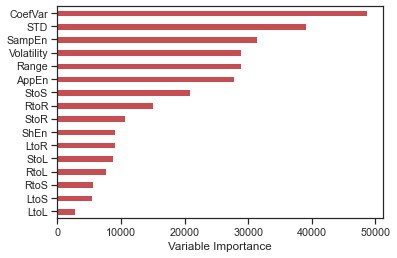

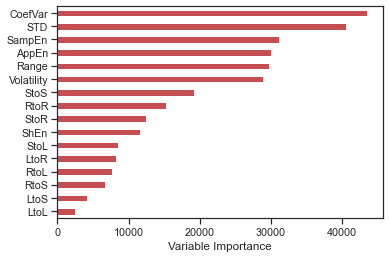

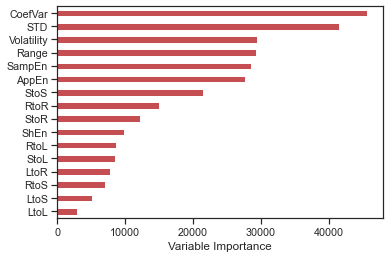

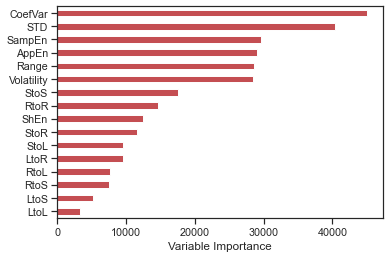

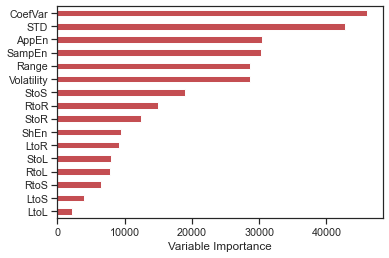

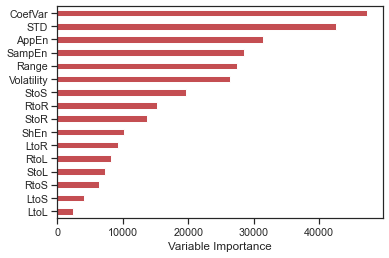

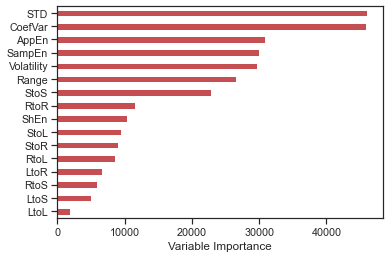

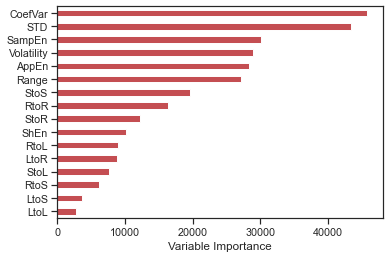

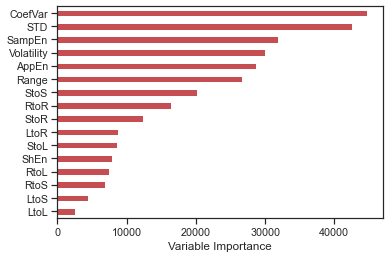

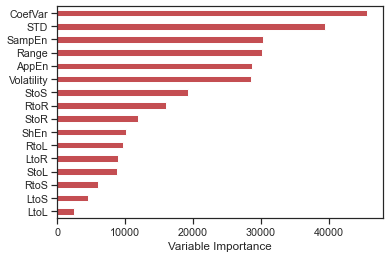

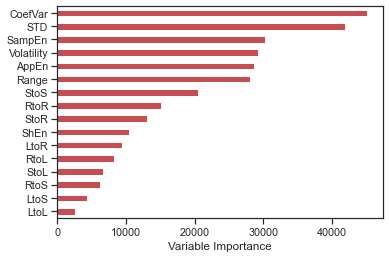

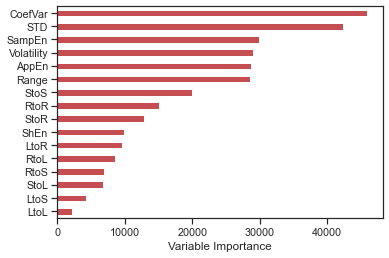

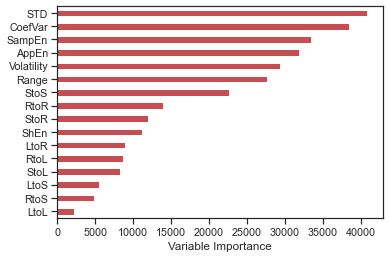

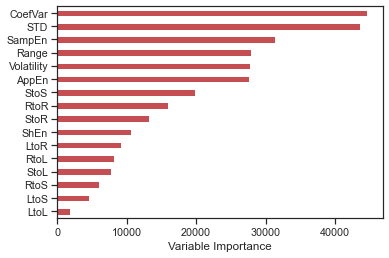

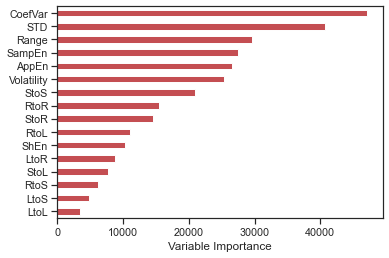

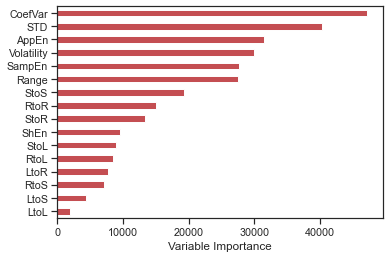

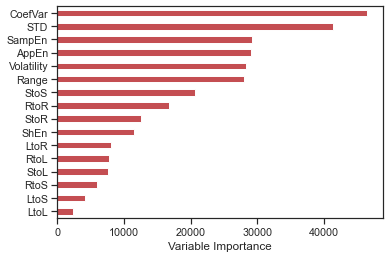

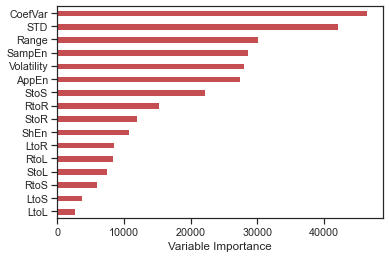

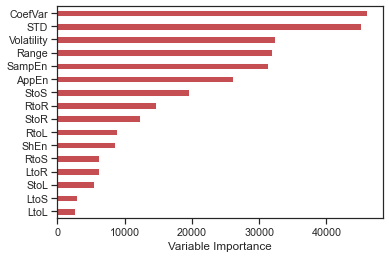

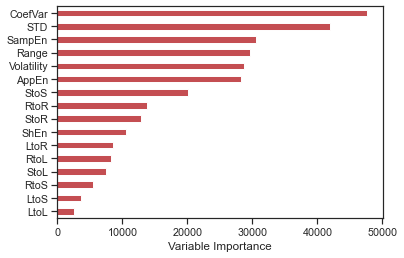

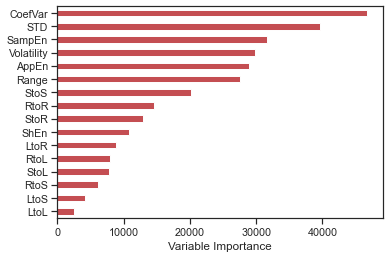

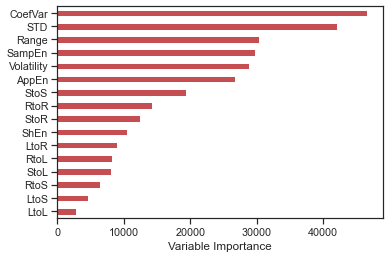

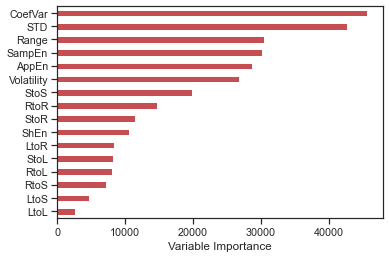

In [9]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)
model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];

x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']


for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]

    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [10]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))

[[23069  1674]
 [ 1706 18519]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.92      0.92     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968



# CatBoosting

In [11]:
# https://catboost.ai/en/docs/concepts/python-quickstart
import catboost as cb
from catboost import CatBoostClassifier


print ('catboost version', cb.__version__)

catboost version 1.0.6


C:\Users\Luke\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


---Run time is 20.15352129999974 seconds ---

Accuracy of each fold: 
 [0.9090389016018307, 0.9557809330628804, 0.9955919395465995, 0.9388489208633094, 0.9973876698014629, 0.9468559837728194, 0.829985987856142, 0.9972770592239619, 0.9392570281124498, 0.9680264608599779, 0.9841197822141561, 0.9892318736539842, 0.7764172335600907, 0.9738853503184713, 0.5024979184013322, 0.9889233495790872, 0.9917751884852639, 0.9838430467397576, 0.7295012679628065, 0.9747113798790544, 0.9970059880239521, 0.9949780288763339, 0.9970401691331924]

Avg accuracy : 
0.9287818026751701

Std of accuracy : 
0.11546461986032915


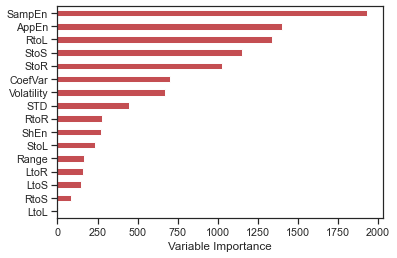

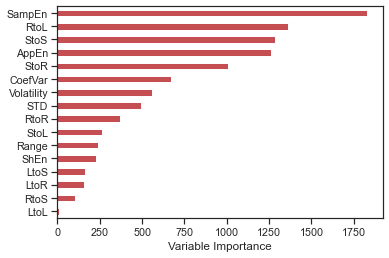

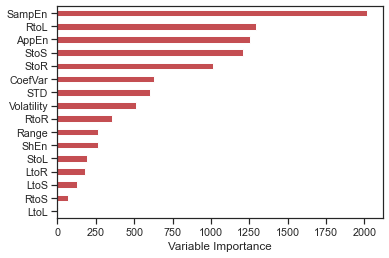

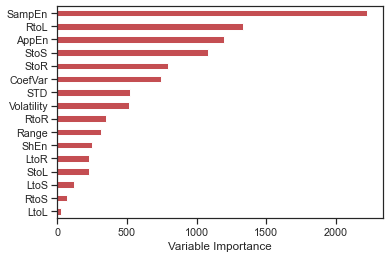

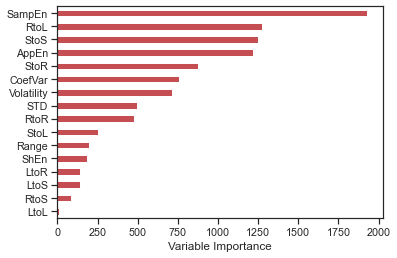

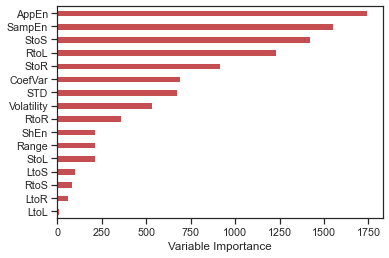

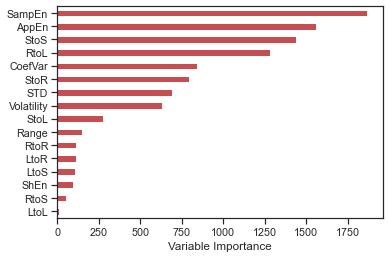

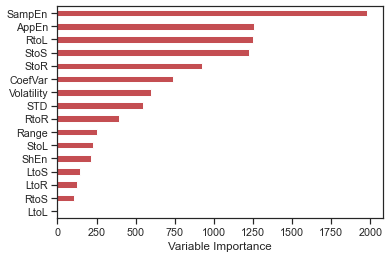

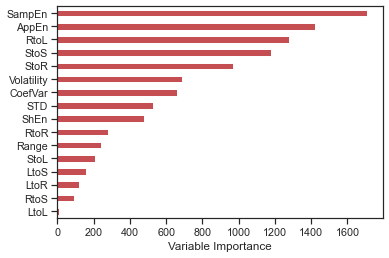

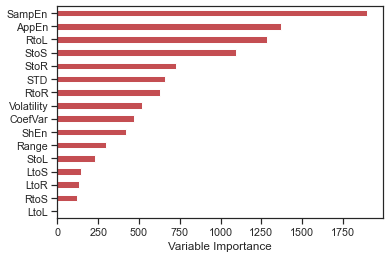

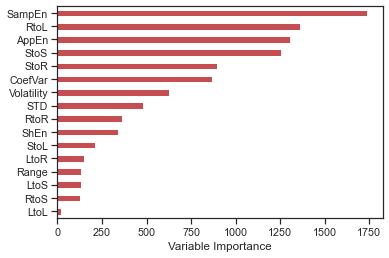

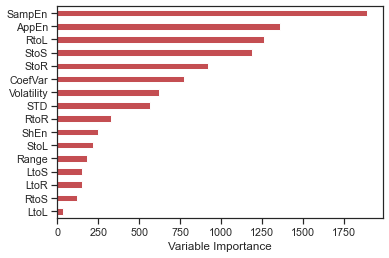

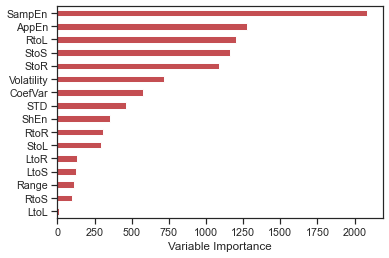

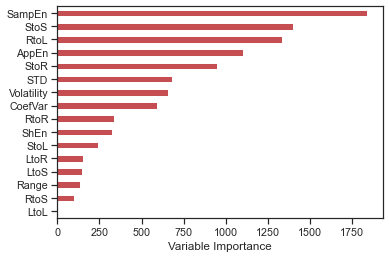

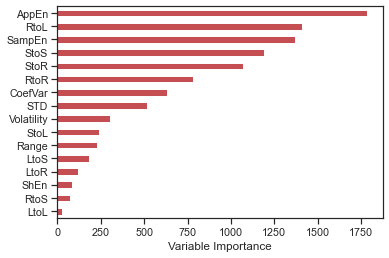

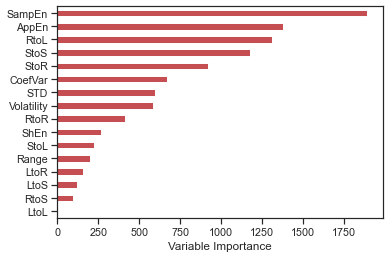

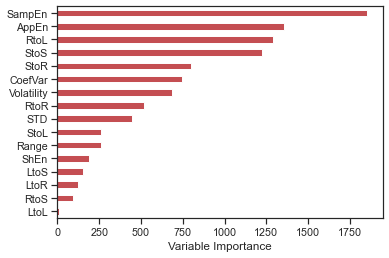

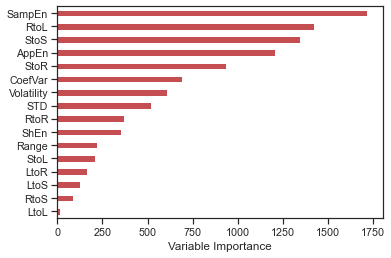

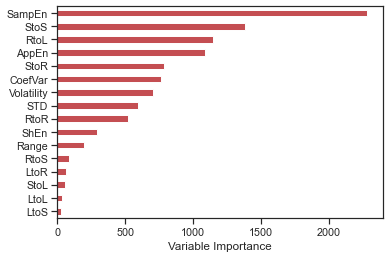

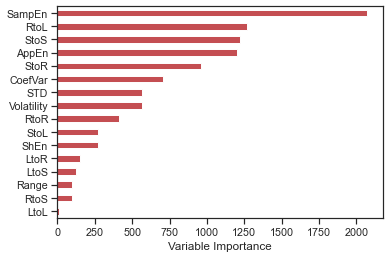

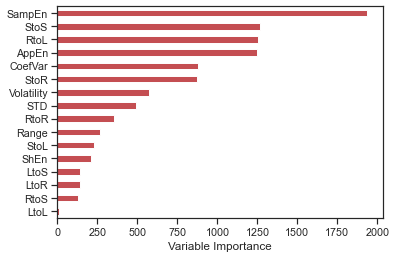

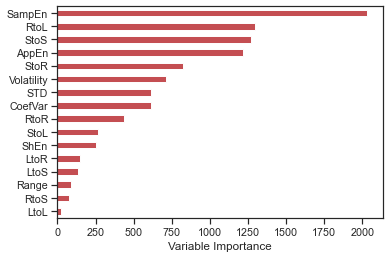

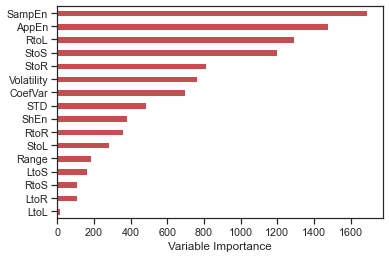

In [14]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
 
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]
    
    # Create CatBoost model
    model = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           loss_function='Logloss')
    # train the model
    model.fit(X_train, y_train, verbose=False)
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [13]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))

[[22950  1793]
 [ 1819 18406]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.91      0.91      0.91     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968



# Please neglect: The following are some codes to be developed

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html